# MiniRocket

MiniRocket transforms input time series using a small, fixed set of convolutional kernels.  MiniRocket uses PPV pooling to compute a single feature for each of the resulting feature maps (i.e., the proportion of positive values). The transformed features are used to train a linear classifier.

Dempster A, Schmidt DF, Webb GI (2020) MiniRocket: A Very Fast (Almost) Deterministic Transform for Time Series Classification [arXiv:2012.08791](https://arxiv.org/abs/2012.08791)

## 1 Univariate Time Series

### 1.1 Imports

Import example data, MiniRocket, `RidgeClassifierCV` (scikit-learn), and NumPy.

**Note**: MiniRocket and MiniRocketMultivariate are compiled by Numba on import.  The compiled functions are cached, so this should only happen once (i.e., the first time you import MiniRocket or MiniRocketMultivariate).

In [1]:
# !pip install --upgrade numba

In [2]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.datasets import (
    load_japanese_vowels,  # multivariate dataset with unequal length
)
from sktime.transformations.panel.rocket import (
    MiniRocket,
    MiniRocketMultivariate,
    MiniRocketMultivariateVariable,
)

### 1.2 Load the Training Data

For more details on the data set, see the [univariate time series classification notebook](https://github.com/sktime/sktime/blob/main/examples/02_classification.ipynb).

**Note**: Input time series must be *at least* of length 9.  Pad shorter time series using, e.g., `PaddingTransformer` (`sktime.transformers.panel.padder`).

<Axes: >

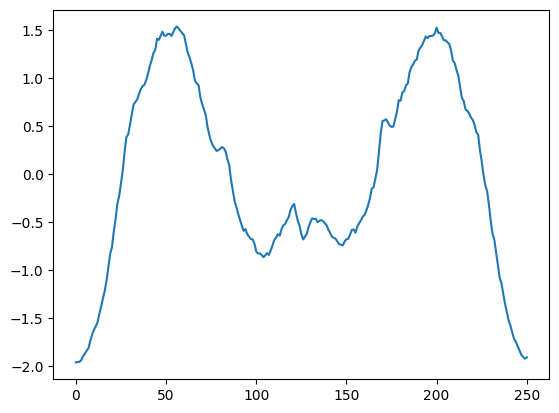

In [3]:
X_train, y_train = load_arrow_head(split="train", return_X_y=True)
# visualize the first univariate time series
X_train.iloc[0, 0].plot()

### 1.3 Initialise MiniRocket and Transform the Training Data

In [4]:
minirocket = MiniRocket()  # by default, MiniRocket uses ~10_000 kernels
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)
# test shape of transformed training data -> (n_instances, 9_996)
X_train_transform.shape

(36, 9996)

### 1.4 Fit a Classifier

We suggest using `RidgeClassifierCV` (scikit-learn) for smaller datasets (fewer than ~10,000 training examples), and using logistic regression trained using stochastic gradient descent for larger datasets.

**Note**: For larger datasets, this means integrating MiniRocket with stochastic gradient descent such that the transform is performed per minibatch, *not* simply substituting `RidgeClassifierCV` for, e.g., `LogisticRegression`.

**Note**: While the input time-series of MiniRocket is unscaled, the output features of MiniRocket may need to be adjusted for following models. E.g. for `RidgeClassifierCV`, we scale the features using the sklearn StandardScaler.

In [5]:
scaler = StandardScaler(with_mean=False)
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

X_train_scaled_transform = scaler.fit_transform(X_train_transform)
classifier.fit(X_train_scaled_transform, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

### 1.5 Load and Transform the Test Data

In [6]:
X_test, y_test = load_arrow_head(split="test", return_X_y=True)
X_test_transform = minirocket.transform(X_test)

### 1.6 Classify the Test Data

In [7]:
X_test_scaled_transform = scaler.transform(X_test_transform)
classifier.score(X_test_scaled_transform, y_test)

0.8628571428571429

***

## 2 Multivariate Time Series

We can use the multivariate version of MiniRocket for multivariate time series input.

### 2.1 Imports

Import MiniRocketMultivariate.

**Note**: MiniRocketMultivariate compiles via Numba on import.

### 2.2 Load the Training Data

**Note**: Input time series must be *at least* of length 9.  Pad shorter time series using, e.g., `PaddingTransformer` (`sktime.transformers.panel.padder`).

In [8]:
X_train, y_train = load_basic_motions(split="train", return_X_y=True)

### 2.3 Initialise MiniRocket and Transform the Training Data

In [9]:
minirocket_multi = MiniRocketMultivariate()
minirocket_multi.fit(X_train)
X_train_transform = minirocket_multi.transform(X_train)

### 2.4 Fit a Classifier

In [10]:
scaler = StandardScaler(with_mean=False)
X_train_scaled_transform = scaler.fit_transform(X_train_transform)

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_scaled_transform, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

### 2.5 Load and Transform the Test Data

In [11]:
X_test, y_test = load_basic_motions(split="test", return_X_y=True)
X_test_transform = minirocket_multi.transform(X_test)

### 2.6 Classify the Test Data

In [12]:
X_test_scaled_transform = scaler.transform(X_test_transform)
classifier.score(X_test_scaled_transform, y_test)

1.0

***

## 3 Pipeline Example

We can use MiniRocket together with `RidgeClassifierCV` (or another classifier) in a pipeline.  We can then use the pipeline like a self-contained classifier, with a single call to `fit`, and without having to separately transform the data, etc.

### 3.1 Imports

In [13]:
# (above)

### 3.2 Initialise the Pipeline

In [14]:
minirocket_pipeline = make_pipeline(
    MiniRocket(),
    StandardScaler(with_mean=False),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
)

### 3.3 Load and Fit the Training Data

**Note**: Input time series must be *at least* of length 9.  Pad shorter time series using, e.g., `PaddingTransformer` (`sktime.transformers.panel.padder`).

In [15]:
X_train, y_train = load_arrow_head(split="train")

# it is necessary to pass y_train to the pipeline
# y_train is not used for the transform, but it is used by the classifier
minirocket_pipeline.fit(X_train, y_train)

Pipeline(steps=[('minirocket', MiniRocket()),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])))])

### 3.4 Load and Classify the Test Data

In [16]:
X_test, y_test = load_arrow_head(split="test")

minirocket_pipeline.score(X_test, y_test)

0.8742857142857143

***

## 4 Pipeline Example with MiniRocketMultivariateVariable and unequal length time-series data

For a further pipeline, we use the extended version of MiniRocket, the  `MiniRocketMultivariateVariable` for variable / unequal length time series data. Following the code implementation of the original paper of miniRocket, we combine it with `RidgeClassifierCV` in a sklearn pipeline.  We can then use the pipeline like a self-contained classifier, with a single call to `fit`, and without having to separately transform the data, etc.


### 4.1 Load japanese_vowels as unequal length dataset
Japanese vowels is a a UCI Archive dataset. 9 Japanese-male speakers were recorded saying the vowels 'a' and 'e'. 
The raw recordings are preprocessed to get a 12-dimensional (multivariate) classification probem. The series lengths are between 7 and 29. 

In [17]:
X_train_jv, y_train_jv = load_japanese_vowels(split="train", return_X_y=True)
# lets visualize the first three voice recordings with dimension 0-11

print("number of samples training: ", X_train_jv.shape[0])
print("series length of recoding 0, dimension 5: ", X_train_jv.iloc[0, 5].shape)
print("series length of recoding 1, dimension 5: ", X_train_jv.iloc[1, 0].shape)

X_train_jv.head(3)

number of samples training:  270
series length of recoding 0, dimension 5:  (20,)
series length of recoding 1, dimension 5:  (26,)


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11
0,0 1.860936 1 1.891651 2 1.939205 3...,0 -0.207383 1 -0.193249 2 -0.239664 3...,0 0.261557 1 0.235363 2 0.258561 3...,0 -0.214562 1 -0.249118 2 -0.291458 3...,0 -0.171253 1 -0.112890 2 -0.041053 3...,0 -0.118167 1 -0.112238 2 -0.102034 3...,0 -0.277557 1 -0.311997 2 -0.383300 3...,0 0.025668 1 -0.027122 2 0.019013 3...,0 0.126701 1 0.171457 2 0.169510 3...,0 -0.306756 1 -0.289431 2 -0.314894 3...,0 -0.213076 1 -0.247722 2 -0.227908 3...,0 0.088728 1 0.093011 2 0.074638 3...
1,0 1.303905 1 1.288280 2 1.332021 3...,0 0.067256 1 0.018672 2 -0.058744 3...,0 0.597720 1 0.631579 2 0.601928 3...,0 -0.271474 1 -0.355112 2 -0.347913 3...,0 -0.236808 1 -0.119216 2 -0.053463 3...,0 -0.411125 1 -0.434425 2 -0.421753 3...,0 -0.014826 1 -0.078036 2 -0.028479 3...,0 0.113175 1 0.178121 2 0.145073 3...,0 -0.058230 1 -0.106430 2 -0.159488 3...,0 -0.173138 1 -0.181910 2 -0.127751 3...,0 0.093058 1 0.093031 2 0.019092 3...,0 0.099247 1 0.099183 2 0.113546 3...
2,0 1.462484 1 1.309815 2 1.418207 3...,0 0.174066 1 0.120183 2 0.015721 3...,0 0.505133 1 0.503046 2 0.589994 3...,0 -0.374302 1 -0.327562 2 -0.310586 3...,0 -0.362125 1 -0.356789 2 -0.477019 3...,0 -0.400335 1 -0.445498 2 -0.367101 3...,0 -0.137429 1 -0.060423 2 -0.120849 3...,0 -0.000830 1 -0.007899 2 0.066952 3...,0 0.053888 1 0.041605 2 -0.023859 3...,0 -0.237630 1 -0.231087 2 -0.224317 3...,0 0.120636 1 0.121053 2 0.175298 3...,0 0.193254 1 0.202386 2 0.156670 3...


Speaker ID:  6


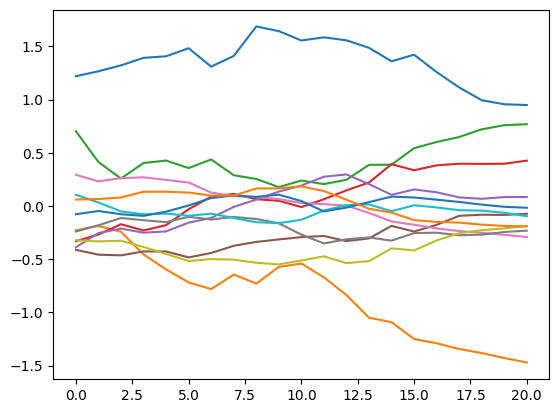

In [18]:
# additional visualizations
number_example = 153
for i in range(12):
    X_train_jv.loc[number_example, f"dim_{i}"].plot()
print("Speaker ID: ", y_train_jv[number_example])

### 4.2 Create a pipeline, train on it
As before, we create a sklearn pipeline. 
MiniRocketMultivariateVariable requires a minimum series length of 9, where missing values are padded up to a length of 9, with the value "-10.0".
Afterwards a scaler and a RidgeClassifierCV are added.


In [19]:
minirocket_mv_var_pipeline = make_pipeline(
    MiniRocketMultivariateVariable(
        pad_value_short_series=-10.0, random_state=42, max_dilations_per_kernel=16
    ),
    StandardScaler(with_mean=False),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
)
print(minirocket_mv_var_pipeline)

minirocket_mv_var_pipeline.fit(X_train_jv, y_train_jv)

Pipeline(steps=[('minirocketmultivariatevariable',
                 MiniRocketMultivariateVariable(max_dilations_per_kernel=16,
                               pad_value_short_series=-10.0, random_state=42)),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])))])


Pipeline(steps=[('minirocketmultivariatevariable',
                 MiniRocketMultivariateVariable(max_dilations_per_kernel=16,
                               pad_value_short_series=-10.0, random_state=42)),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])))])

### 4.3 Score the Pipeline on japanese vowels

Using the MiniRocketMultivariateVariable, we are able to process also process slightly larger input series than at train time.
train max series length: 27, test max series length 29

In [20]:
X_test_jv, y_test_jv = load_japanese_vowels(split="test", return_X_y=True)

minirocket_mv_var_pipeline.score(X_test_jv, y_test_jv)

0.9945945945945946